<a href="https://colab.research.google.com/github/abartnof/worldwide_ed/blob/main/education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Worldwide trends in teacher metrics and PISA performance

- [git repo](https://github.com/abartnof/worldwide_ed)
- [@abartnof](https://github.com/abartnof)

# Load packages

Colab assigns a fresh R Kernel everytime this runs, so preface the script by installing these packages

In [1]:
install.packages('ggrepel')
install.packages('lavaan')
install.packages('maps')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘tmvnsim’, ‘mnormt’, ‘pbivnorm’, ‘numDeriv’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(lavaan))
suppressPackageStartupMessages(library(tidyverse))
options(repr.plot.width = 12, repr.plot.height = 8)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# ETL

- All of the following datasets come from the OECD.
- In order to be able to compare disparate metrics (e.g. teachers\' paychecks v. how many hours teachers work per year), all of these data are ultimately converted into percentiles.
  - Percentiles allow us to discuss countries in terms of their rank-ordering
  - They also don't make any parametric assumptions, like standard deviations do
- The PISA is applied to students at both public and private universities
  - However, most students attend public schools, and at least one of these key metrics only applies to public school teachers-- as a result, filter all of these indicators to represent public school data only

In [3]:
Data <- new.env()

## Ratio of students to teachers
[OECD data](http://dx.doi.org/10.1787/334a3b64-en)
- Filter to public schools only
- Aggregate across all grades

In [4]:
Data$RawRatio <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/ratio.csv', col_types = cols(.default = 'c'))

In [5]:
Data$Ratio <-
  Data$RawRatio %>%
  select(
    country_abbrev = COUNTRY,
    country = Country,
    ed_level_code = 'ISC11_LEVEL_CAT',
    ed_level = 'Level of education',
    sector = 'Reference sector',
    indicator = Indicator,
    year = Year,
    value = Value
  ) %>%
  filter(
    indicator == 'Ratio of students to teaching staff by type of institutions',
    sector == 'Public educational institutions') %>%
  mutate(
    value = parse_number(value),
    country = recode(country,
      'Russia' = 'Russian Federation')
  ) %>%
  drop_na(value) %>%
  
  # Aggregate across grade levels
  group_by(country, indicator) %>%
  summarize(value = median(value)) %>%
  ungroup %>%

  mutate(
    percentile = ecdf(value)(value),
    percentile_bin = cut(percentile, breaks = seq(0, 1, by = 0.2), include.lowest = T, ordered_result = T)
  )

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



## Teachers' working time
[OECD data](https://www.oecd-ilibrary.org/education/data/education-at-a-glance/teachers-teaching-and-working-time_d3ca76db-en)
- Filter to working time, not just teaching time
- Aggregate across all grades
- This data represents public school teachers

In [6]:
Data$RawTimeWorking <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/time_working.csv', col_types = cols(.default = 'c'))

In [7]:
Data$TimeWorking <-
  Data$RawTimeWorking %>%
  select(
    country = Country,
    indicator = Indicator,
    value = Value
  ) %>%
  filter(indicator == 
    'Total statutory working time per school year, in hours (teachers)'
  ) %>%
  mutate(
    value = parse_number(value),
  ) %>%
  drop_na(value) %>%

  # Aggregate over grades
  group_by(country, indicator) %>%
  summarize(value = median(value)) %>%
  ungroup %>%

  select(country, indicator, value) %>%
  mutate(
    percentile = ecdf(value)(value),
    percentile_bin = cut(percentile, breaks = seq(0, 1, by = 0.2), include.lowest = T, ordered_result = T)
  )

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



## Teachers\' salaries
[OECD data](https://www.oecd-ilibrary.org/education/data/education-database/educational-expenditure-by-educational-level_c1267206-en)
- Filter to "Annual average salaries (including bonuses and allowances) of teachers in public institutions, in equivalent USD converted using PPPs for private consumption" 
- Exclude breakdowns by gender-- just use total figures
- Aggregate across grades

In [8]:
Data$RawSalary <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/salary.csv', col_types = cols(.default = 'c'))

In [9]:
Data$Salary <- 
  Data$RawSalary %>%
  select(
    country = Country,
    gender = Gender, 
    indicator = Indicator,
    value = Value
  ) %>%
  filter(
    str_detect(indicator, 'PPP'),
    gender == 'Total',
    country != 'European Union 23 members in OECD',
    country != 'OECD Average') %>%
  mutate(
      value = parse_number(value),
  ) %>%
  drop_na(value) %>%
  # Aggregate over grades
  group_by(country, indicator) %>%
  summarize(value = median(value)) %>%
  ungroup %>%

  mutate(
    percentile = ecdf(value)(value),
    percentile_bin = cut(percentile, breaks = seq(0, 1, by = 0.2), include.lowest = T, ordered_result = T)
  )

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



## Social outcomes
[OECD data](https://www.oecd-ilibrary.org/education/data/education-at-a-glance/education-and-social-outcomes_6da66a89-en)
- Filter out 'Percentage of adults who reported that over the last 12 months it has been difficult for them to concentrate at work because of their family responsibilities'-- this is family encroaching on work, while the goal of this analysis is to look at work encroaching on family

In [10]:
Data$RawSocialOutcomes <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/social_outcomes.csv', col_types = cols(.default = 'c'))

In [11]:
Data$SocialOutcomes <-
  Data$RawSocialOutcomes %>%
  filter(
    Age == '25-64 years',
    `ISCED-A 2011` == 'All levels of education',
    Measure == 'Value',
    Indicator !=  'Percentage of adults who reported that over the last 12 months it has been difficult for them to concentrate at work because of their family responsibilities'
    ) %>%
  select(
      country = Country,
      indicator = Indicator,
      value = Value
  ) %>%
  mutate(
    value = parse_number(value),
    country = recode(country,
      'England' = 'England (UK)',
      'Russia' = 'Russian Federation'),
    indicator_concise = recode(indicator,
    'Mean number of hours worked per week in the main job among employed adults' = 'hours_worked',
    'Percentage of employed adults who report having a high or very high flexibility of working hours in their main job' = 'work_flexibility',
    'Percentage of adults who reported that over the last 12 months it has been difficult for them to fulfil their family responsibilities because of the amount of time they spend at work' = 'conflict_work_family_time',
    'Percentage of adults who read books at least once a week, by labour-force status, gender, age and educational attainment' = 'read_books'
    ),
    indicator = str_replace(indicator, 'fulfil ', 'fulfill ')
  ) 

## PISA: Programme for International Student Assessment
https://www.oecd-ilibrary.org/education/data/oecd-education-statistics/pisa-programme-for-international-student-assessment_data-00365-en

The PISA subject scores correlate so highly, they're essentially
redundant ([correlation matrix](https://colab.research.google.com/drive/1GMMEc6AJJ7UOKEx_FHjYNVeMG9jL0ij5#scrollTo=0yLqR8uafTsU)). 
As a result, we can make life simple and just represent each country's PISA performance as the median value of these three evaluations.

In [12]:
Data$RawPisa <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/pisa_2018.csv', col_types = 'icic')

In [13]:
Data$Pisa <-
  Data$RawPisa %>%
  mutate(
    country = recode(country,
      'China (B-S-J-Z)[note 1]' = 'China (People\'s Republic of)',
      'Macau(China)' = 'Macau (China)',
      'Hong Kong(China)' = 'Hong Kong (China)',
      'Russia' = 'Russian Federation',
      'Slovakia' = 'Slovak Republic',
      'South Korea' = 'Korea'
    ))

Data$PisaAgg <-
  Data$Pisa %>%
  drop_na(score) %>%
  group_by(country) %>%
  summarize(
    score = median(score)
    ) %>%
  ungroup %>%
  mutate(
    pisa_sd = as.vector(scale(score)),
    pisa_percentile = ecdf(score)(score),
    pisa_percentile_bin = cut(pisa_percentile, breaks = seq(0, 1, by = 0.2), include.lowest = T, ordered_result = T)
    )

## Map of the world
Use the maps package to get a map of the world

In [14]:
Data$World <- map_data('world')

Data$World <-
  Data$World %>%
    mutate(
      region = recode(region,
        'China' = 'China (People\'s Republic of)',
        'South Korea' = 'Korea',
        'Russia' = 'Russian Federation',
        'Slovakia' = 'Slovak Republic',
        'UK' = 'United Kingdom',
        'USA' = 'United States',
        'Macedonia' = 'North Macedonia'
        )) %>%
    filter(region != 'Antarctica')

# Pisa subject correlations
The Spearman's rho between the subjects is essentially perfect. As a result, we'll just take each country's median score from these three subjects.

In [15]:
rho <-
  Data$Pisa %>%
  spread(subject, score) %>%
  select(mathematics, reading, science) %>%
  cor(use = 'pairwise.complete.obs', method = 's')

rho[upper.tri(rho, diag = T)] <- NA_real_
rho

,mathematics,reading,science
mathematics,NA,NA,NA
reading,1.000000,NA,NA
science,0.996696,1,NA


# Maps and IVs

Create labels so that it's easy to understand what these quantiles really mean

In [16]:
ratio_labels <- c(
    '[0,0.2] (fewer students per teacher)', 
    '(0.2,0.4]', 
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1] (more students per teacher)')

salary_labels <- c(
    '[0,0.2] (smaller salary)', 
    '(0.2,0.4]', 
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1] (larger salary)')

time_use_labels <- c(
    '[0,0.2] (less time)', 
    '(0.2,0.4]', 
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1] (more time)')

pisa_labels <- c(
    '[0,0.2] (lower score)', 
    '(0.2,0.4]', 
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1] (higher score)')

## Plot choropleths

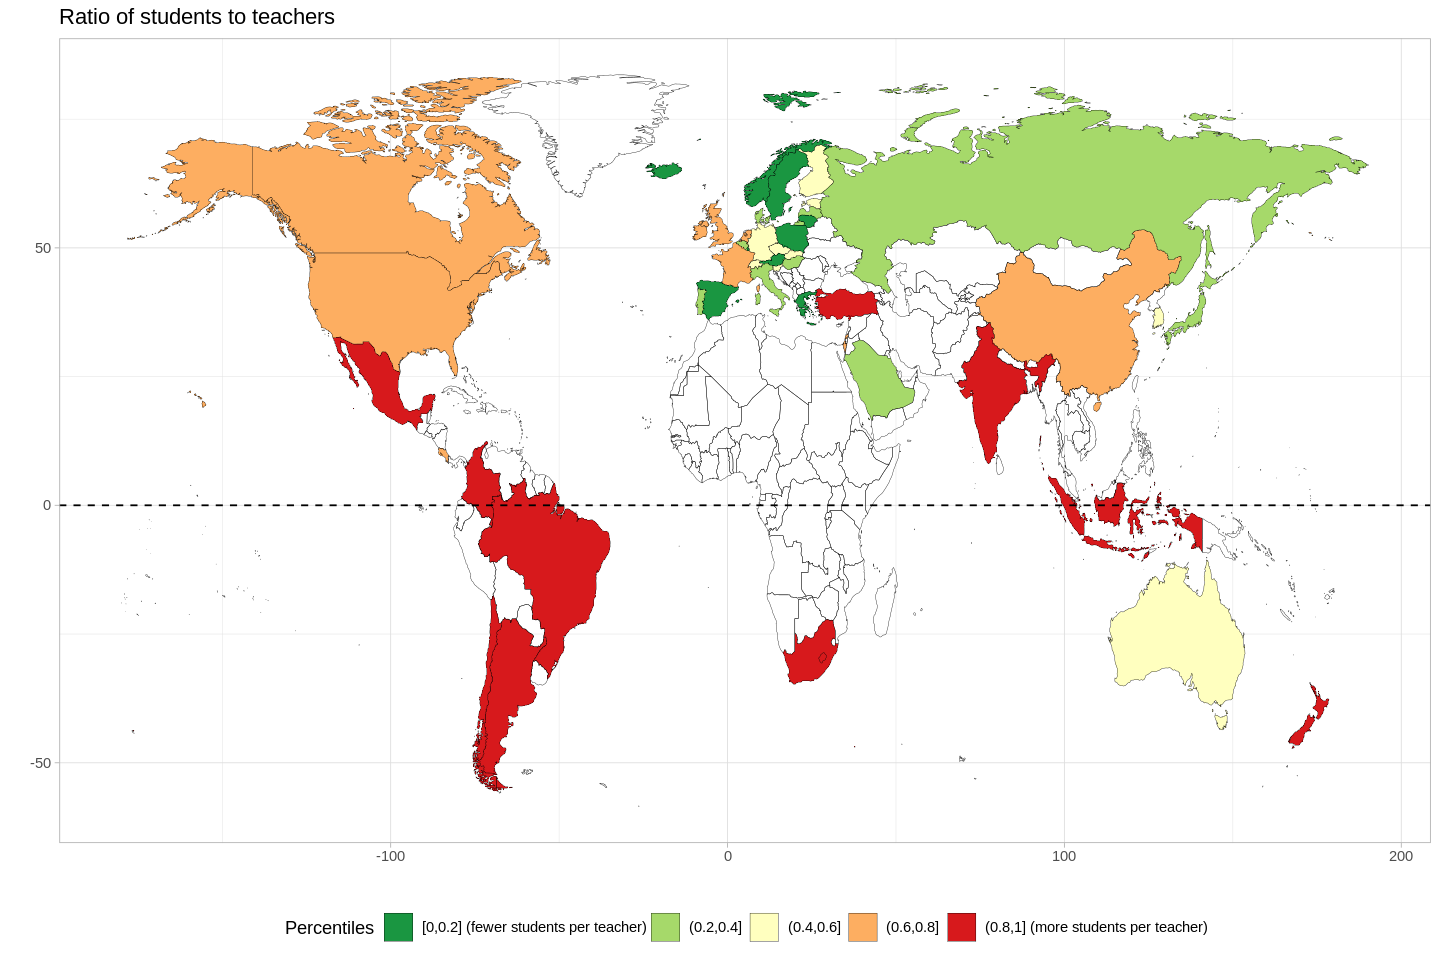

In [17]:
Data$Ratio %>%
right_join(Data$World, by = c('country' = 'region')) %>%

ggplot(., aes(x = long, y = lat, group = group, fill = percentile_bin)) +
geom_polygon(color = 'black', size = 0.1) +
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_fill_brewer(
  palette = 'RdYlGn', 
  direction = -1,
  breaks = c(
    '[0,0.2]',
    '(0.2,0.4]',
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1]'),
  labels = ratio_labels) +
guides(fill = guide_legend(nrow = 1)) +
theme_light() +
theme(legend.position = 'bottom') +
labs(x = '', y = '', 
  title = 'Ratio of students to teachers', 
  fill = 'Percentiles')

In [18]:
Data$Salary$indicator[[1]]

[1] "\"Annual average salaries (including bonuses and allowances) of teachers in public institutions, in equivalent USD converted using PPPs for private consumption\""

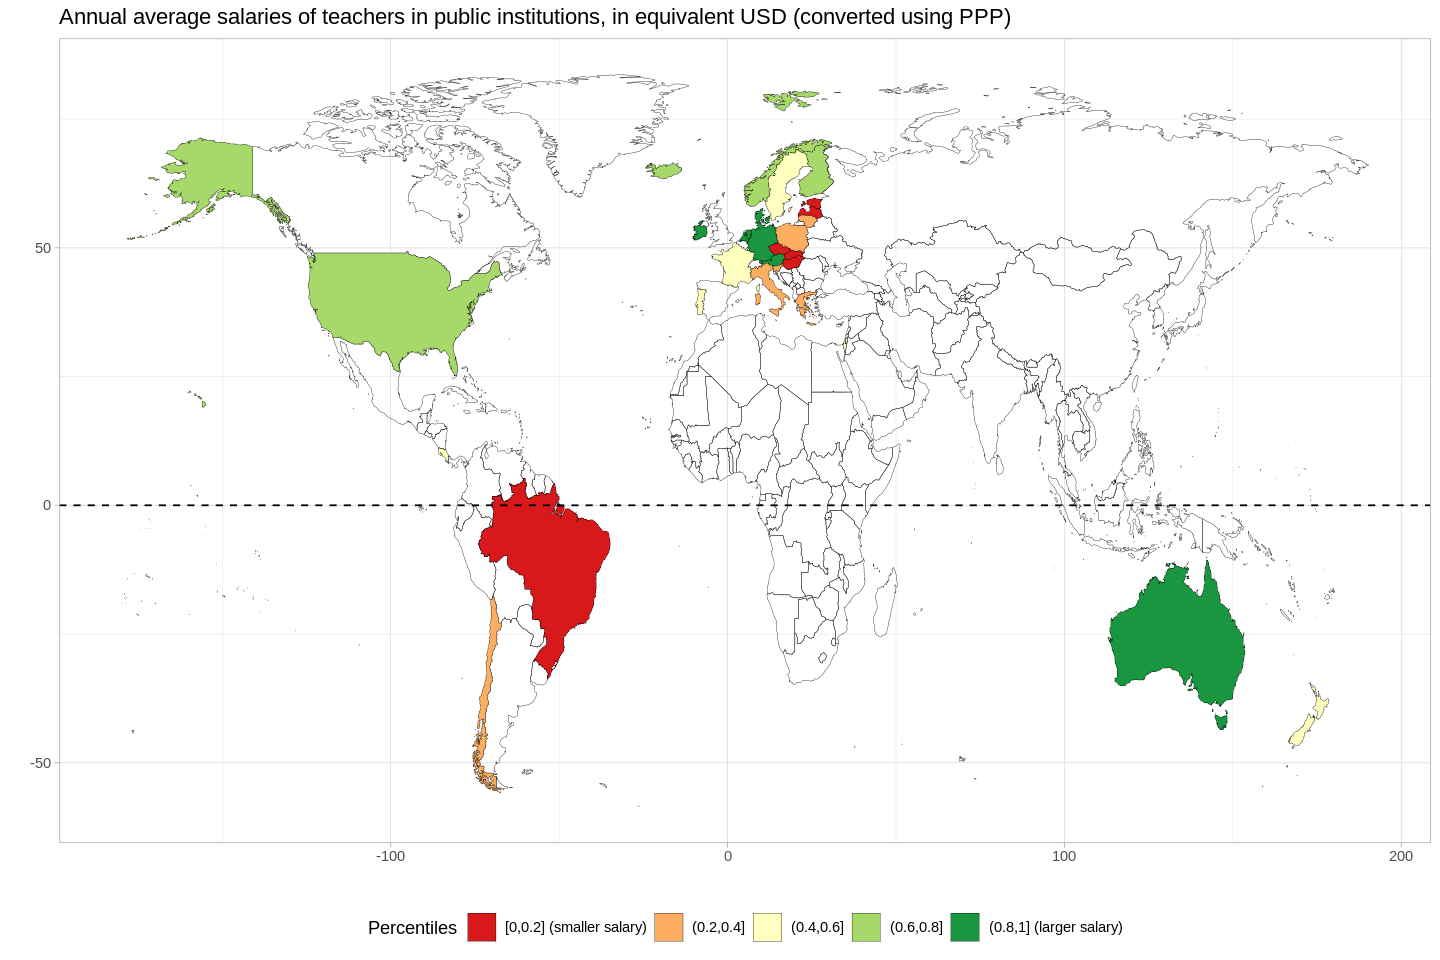

In [19]:
Data$Salary %>%
right_join(Data$World, by = c('country' = 'region')) %>%

ggplot(., aes(x = long, y = lat, group = group, fill = percentile_bin)) +
geom_polygon(color = 'black', size = 0.1) +
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_fill_brewer(
  palette = 'RdYlGn', 
  # direction = -1,
  breaks = c(
    '[0,0.2]',
    '(0.2,0.4]',
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1]'),
  labels = salary_labels) +
guides(fill = guide_legend(nrow = 1)) +
theme_light() +
theme(legend.position = 'bottom') +
labs(x = '', y = '', 
  title = 'Annual average salaries of teachers in public institutions, in equivalent USD (converted using PPP)', 
  fill = 'Percentiles')

In [20]:
Data$TimeWorking$indicator[[1]]

[1] "Total statutory working time per school year, in hours (teachers)"

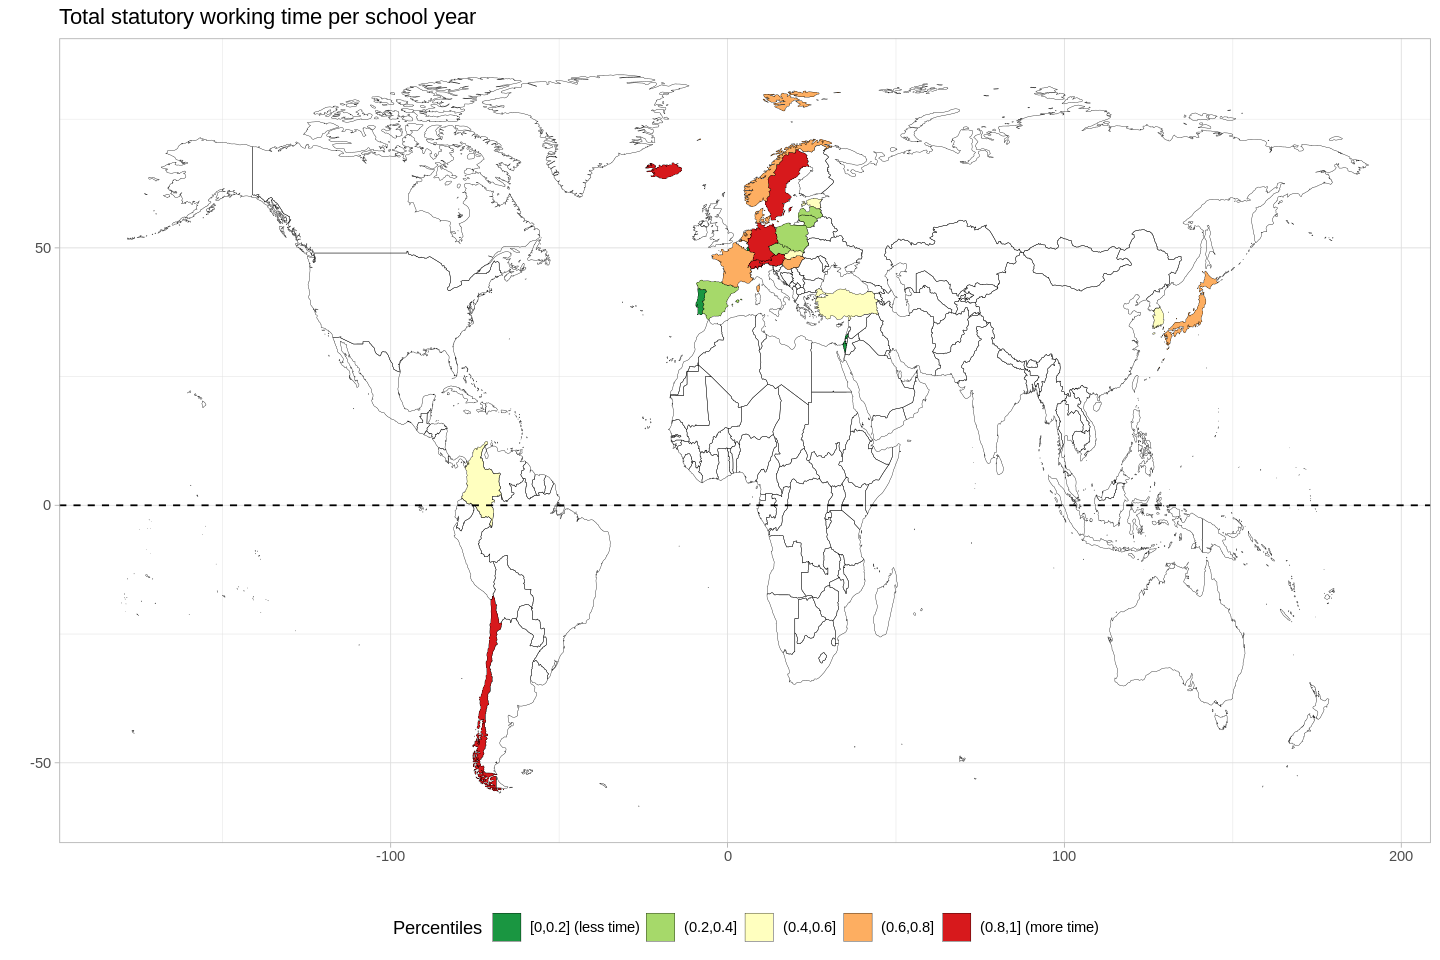

In [21]:
Data$TimeWorking %>%
right_join(Data$World, by = c('country' = 'region')) %>%

ggplot(., aes(x = long, y = lat, group = group, fill = percentile_bin)) +
geom_polygon(color = 'black', size = 0.1) +
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_fill_brewer(
  palette = 'RdYlGn', 
  direction = -1,
  breaks = c(
    '[0,0.2]',
    '(0.2,0.4]',
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1]'),
  labels = time_use_labels) +
guides(fill = guide_legend(nrow = 1)) +
theme_light() +
theme(legend.position = 'bottom') +
labs(x = '', y = '', 
  title = 'Total statutory working time per school year', 
  fill = 'Percentiles')

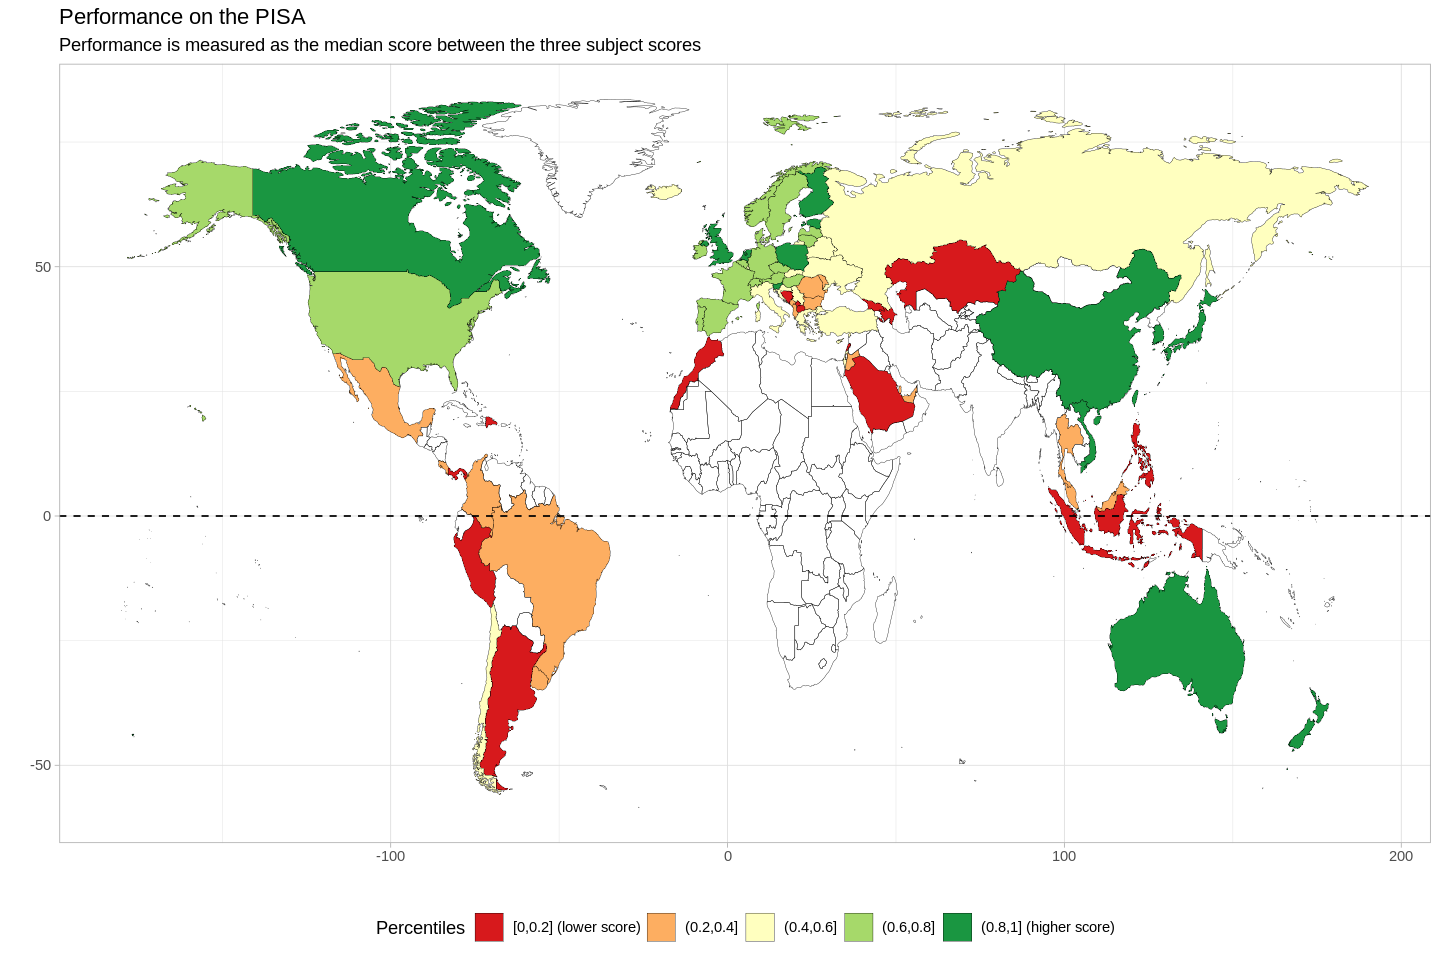

In [22]:
Data$PisaAgg %>%
right_join(Data$World, by = c('country' = 'region')) %>%

ggplot(., aes(x = long, y = lat, group = group, fill = pisa_percentile_bin)) +
geom_polygon(color = 'black', size = 0.1) +
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_fill_brewer(
  palette = 'RdYlGn', 
  # direction = -1,
  breaks = c(
    '[0,0.2]',
    '(0.2,0.4]',
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1]'),
  labels = pisa_labels) +
guides(fill = guide_legend(nrow = 1)) +
theme_light() +
theme(legend.position = 'bottom') +
labs(x = '', y = '', 
  title = 'Performance on the PISA', 
  subtitle = 'Performance is measured as the median score between the three subject scores',
  fill = 'Percentiles')

## Plot real values using lollipops

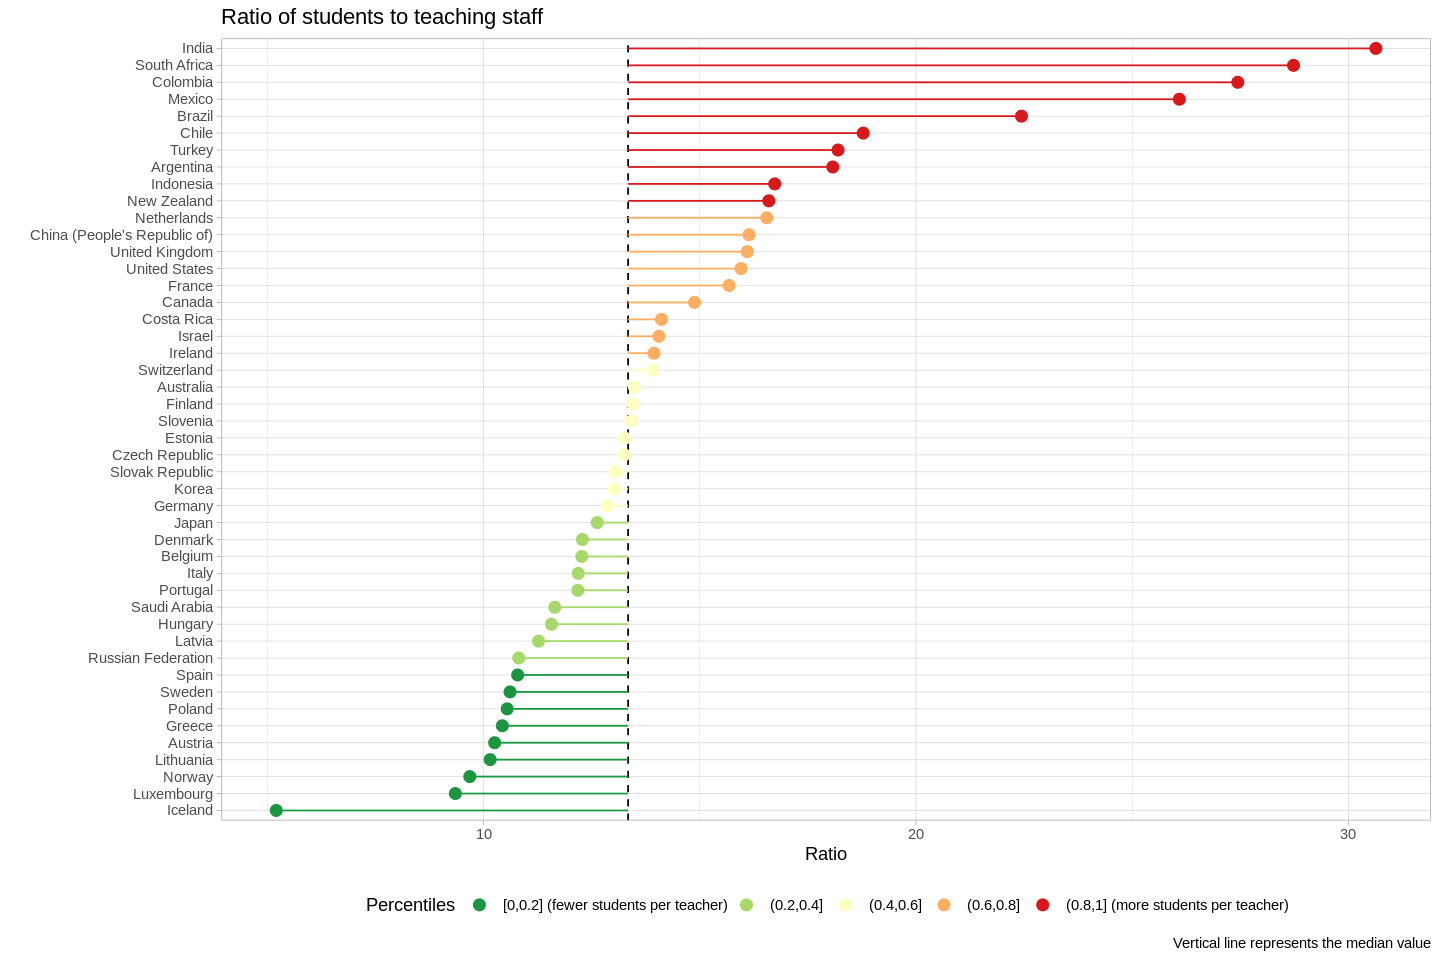

In [23]:
Data$Ratio %>%
drop_na %>%
mutate(
  country = fct_reorder(country, value),
  median_value = median(value)
) %>%

ggplot(aes(x = country, y = value, color = percentile_bin)) +
geom_hline(aes(yintercept = median_value), linetype = 'dashed') +
geom_segment(aes(xend = country, yend = median_value), show.legend = F) +
geom_point(size = 3) +
coord_flip() +
scale_color_brewer(
  palette = 'RdYlGn',
  direction = -1,
  labels = ratio_labels) +
theme_light() +
theme(legend.position = 'bottom') +
labs(
  x = '', 
  title = 'Ratio of students to teaching staff', 
  y = 'Ratio', 
  color = 'Percentiles',
  caption = 'Vertical line represents the median value')

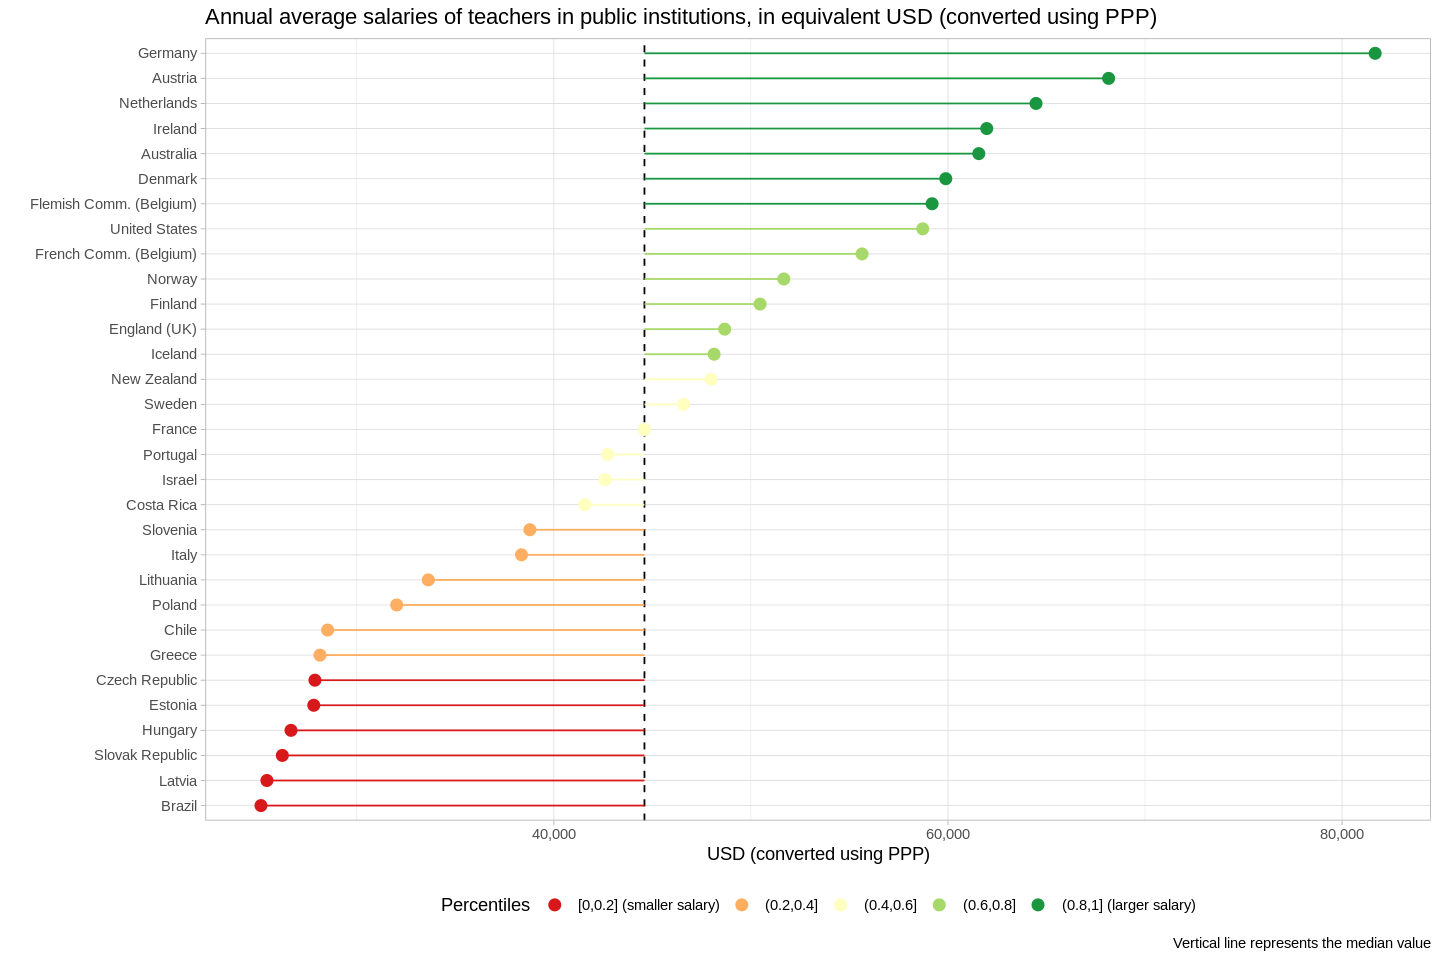

In [24]:
Data$Salary %>%
mutate(
  country = fct_reorder(country, value),
  median_value = median(value)
) %>%

ggplot(aes(x = country, y = value, color = percentile_bin)) +
geom_hline(aes(yintercept = median_value), linetype = 'dashed') +
geom_segment(aes(xend = country, yend = median_value), show.legend = F) +
geom_point(size = 3) +
coord_flip() +
scale_y_continuous(labels = scales::comma_format(1)) +
scale_color_brewer(
  palette = 'RdYlGn',
  # direction = -1,
  labels = salary_labels) +
theme_light() +
theme(legend.position = 'bottom') +
labs(
  x = '', 
  title = 'Annual average salaries of teachers in public institutions, in equivalent USD (converted using PPP)',
  caption = 'Vertical line represents the median value',
  y = 'USD (converted using PPP)', 
  color = 'Percentiles')

In [25]:
Data$TimeWorking$indicator[[1]]

[1] "Total statutory working time per school year, in hours (teachers)"

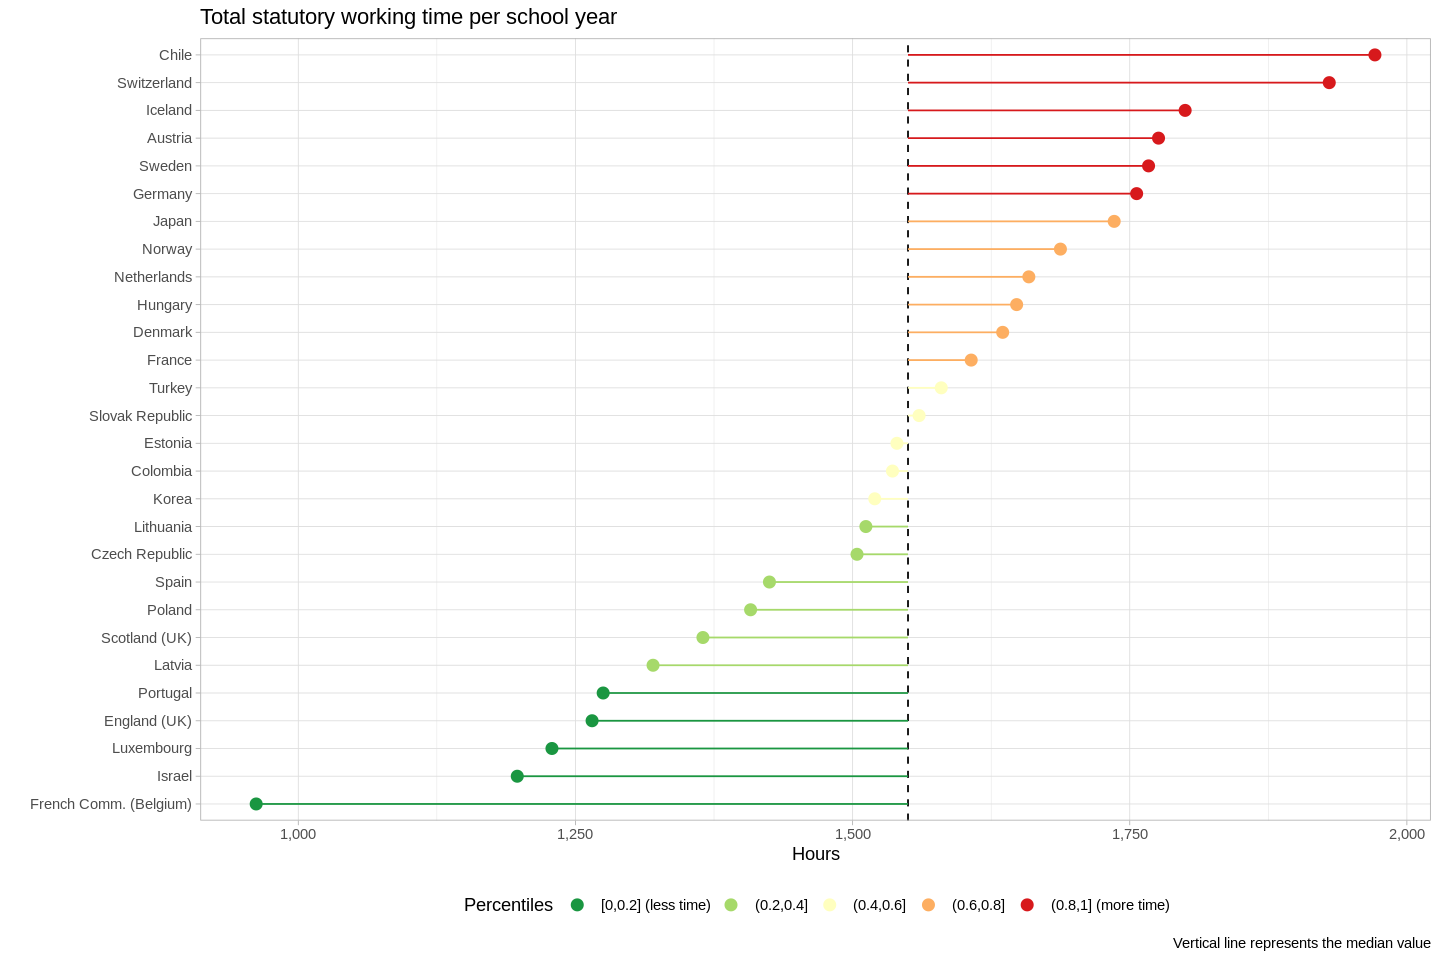

In [26]:
Data$TimeWorking %>%
mutate(
  country = fct_reorder(country, value),
  median_value = median(value)
) %>%

ggplot(aes(x = country, y = value, color = percentile_bin)) +
geom_hline(aes(yintercept = median_value), linetype = 'dashed') +
geom_segment(aes(xend = country, yend = median_value), show.legend = F) +
geom_point(size = 3) +
coord_flip() +
scale_y_continuous(labels = scales::comma_format(1)) +
scale_color_brewer(
  palette = 'RdYlGn',
  direction = -1,
  labels = time_use_labels) +
theme_light() +
theme(legend.position = 'bottom') +
labs(
  x = '', 
  title = 'Total statutory working time per school year',
  caption = 'Vertical line represents the median value',
  y = 'Hours', 
  color = 'Percentiles')

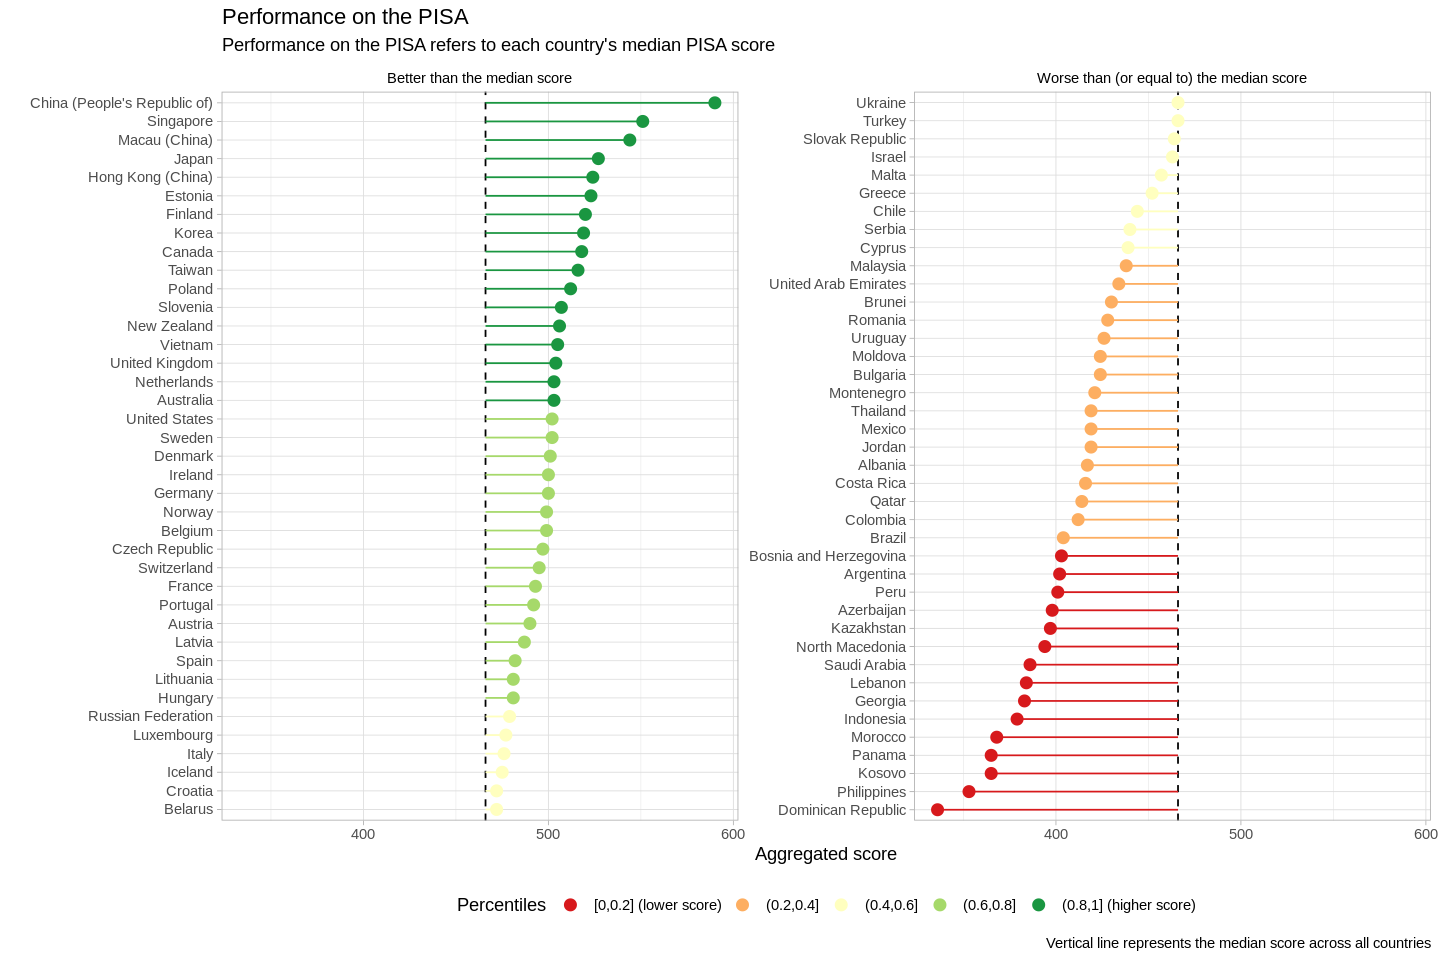

In [27]:
Data$PisaAgg %>%
mutate(
  country = fct_reorder(country, score),
  median_score = median(score),
  my_facet = if_else(score > median_score, 'Better than the median score', 'Worse than (or equal to) the median score'),
) %>%

ggplot(aes(x = country, y = score, color = pisa_percentile_bin)) +
geom_hline(aes(yintercept = median_score), linetype = 'dashed') +
geom_segment(aes(xend = country, yend = median_score), show.legend = F) +
geom_point(size = 3) +
coord_flip() +
scale_y_continuous(labels = scales::comma_format(1)) +
scale_color_brewer(
  palette = 'RdYlGn',
  labels = pisa_labels) +
facet_wrap(~my_facet, scales = 'free_y') +
theme_light() +
theme(
  strip.text = element_text(color = 'black'),
  strip.background = element_blank(),
  legend.position = 'bottom') +
labs(
  x = '', 
  title = 'Performance on the PISA', 
  subtitle = 'Performance on the PISA refers to each country\'s median PISA score',
  caption = 'Vertical line represents the median score across all countries',
  y = 'Aggregated score', 
  color = 'Percentiles')

## Boxplots representing the relationship between teacher metrics and PISA scores

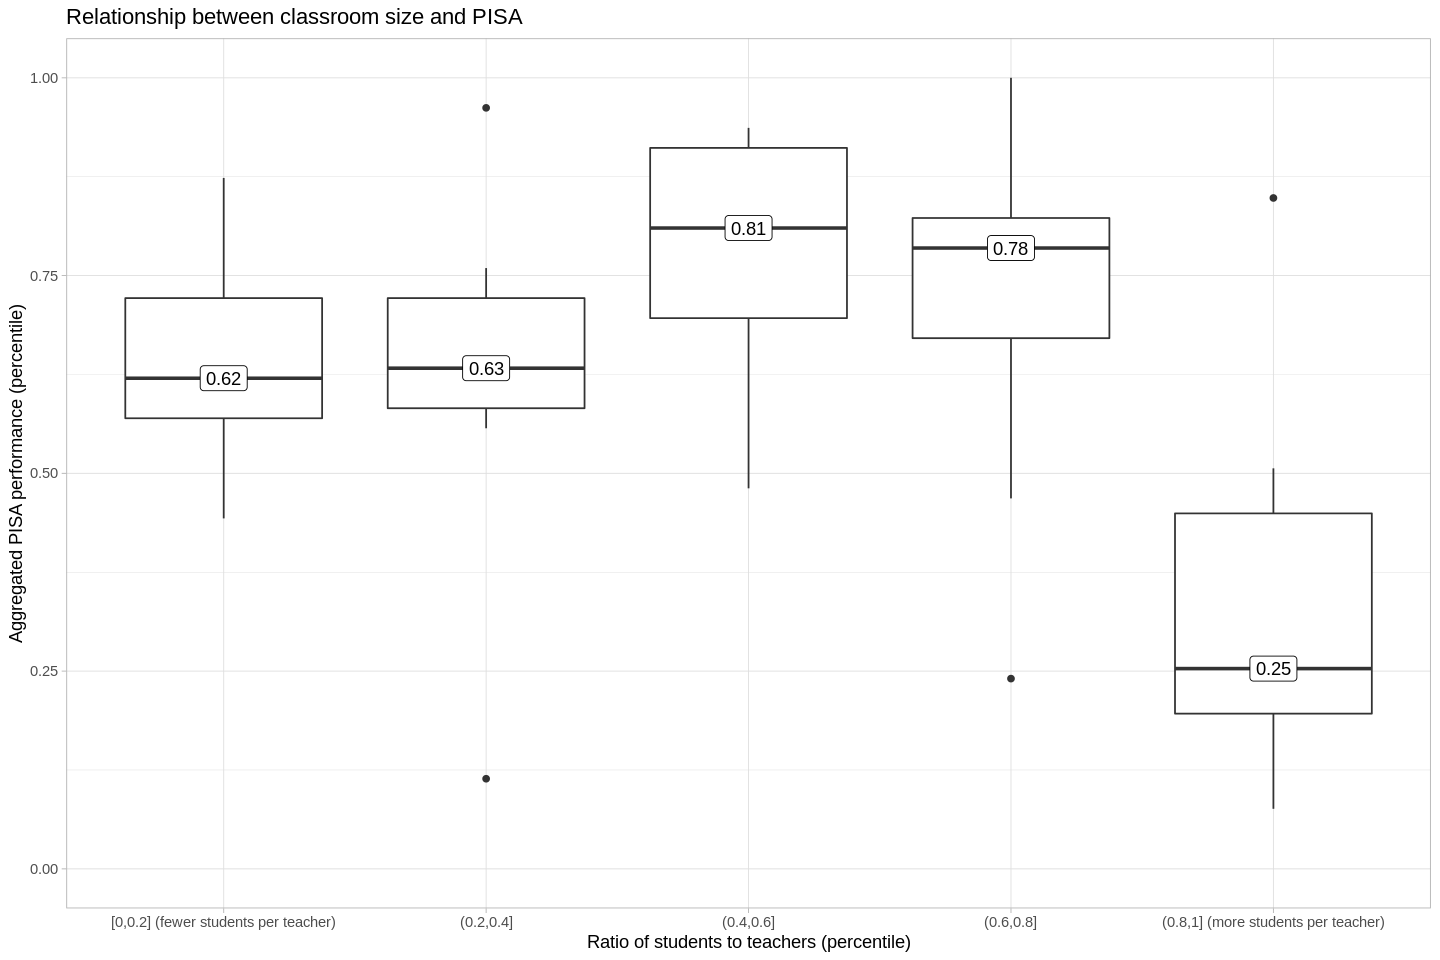

In [28]:
with(Data, inner_join(Ratio, PisaAgg, by = 'country')) %>%
ggplot(aes(x = percentile_bin, y = pisa_percentile)) +
geom_boxplot() +
stat_summary(fun = 'median', geom = 'label', aes(label = round(..y.., 2))) +
scale_x_discrete(labels = ratio_labels) +
coord_cartesian(ylim = c(0, 1)) +
theme_light() +
labs(
  title = 'Relationship between classroom size and PISA',
  x = 'Ratio of students to teachers (percentile)',
  y = 'Aggregated PISA performance (percentile)'
)

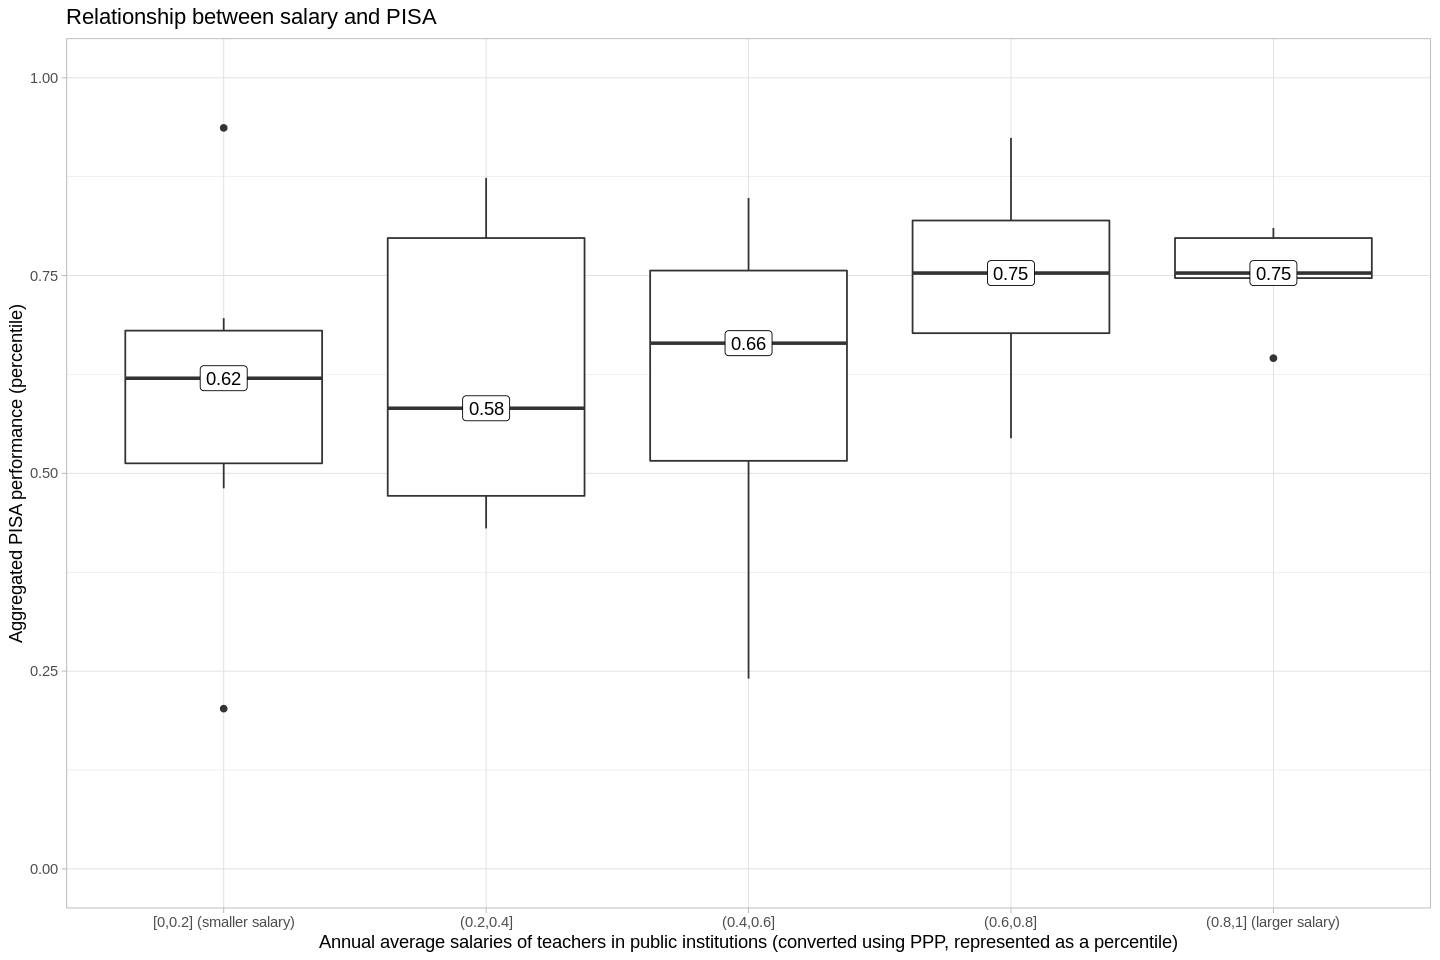

In [29]:
with(Data, inner_join(Salary, PisaAgg, by = 'country')) %>%
ggplot(aes(x = percentile_bin, y = pisa_percentile)) +
geom_boxplot() +
stat_summary(fun = 'median', geom = 'label', aes(label = round(..y.., 2))) +
scale_x_discrete(labels = salary_labels) +
coord_cartesian(ylim = c(0, 1)) +
theme_light() +
labs(
  title = 'Relationship between salary and PISA',
  x = 'Annual average salaries of teachers in public institutions (converted using PPP, represented as a percentile)',
  y = 'Aggregated PISA performance (percentile)'
)

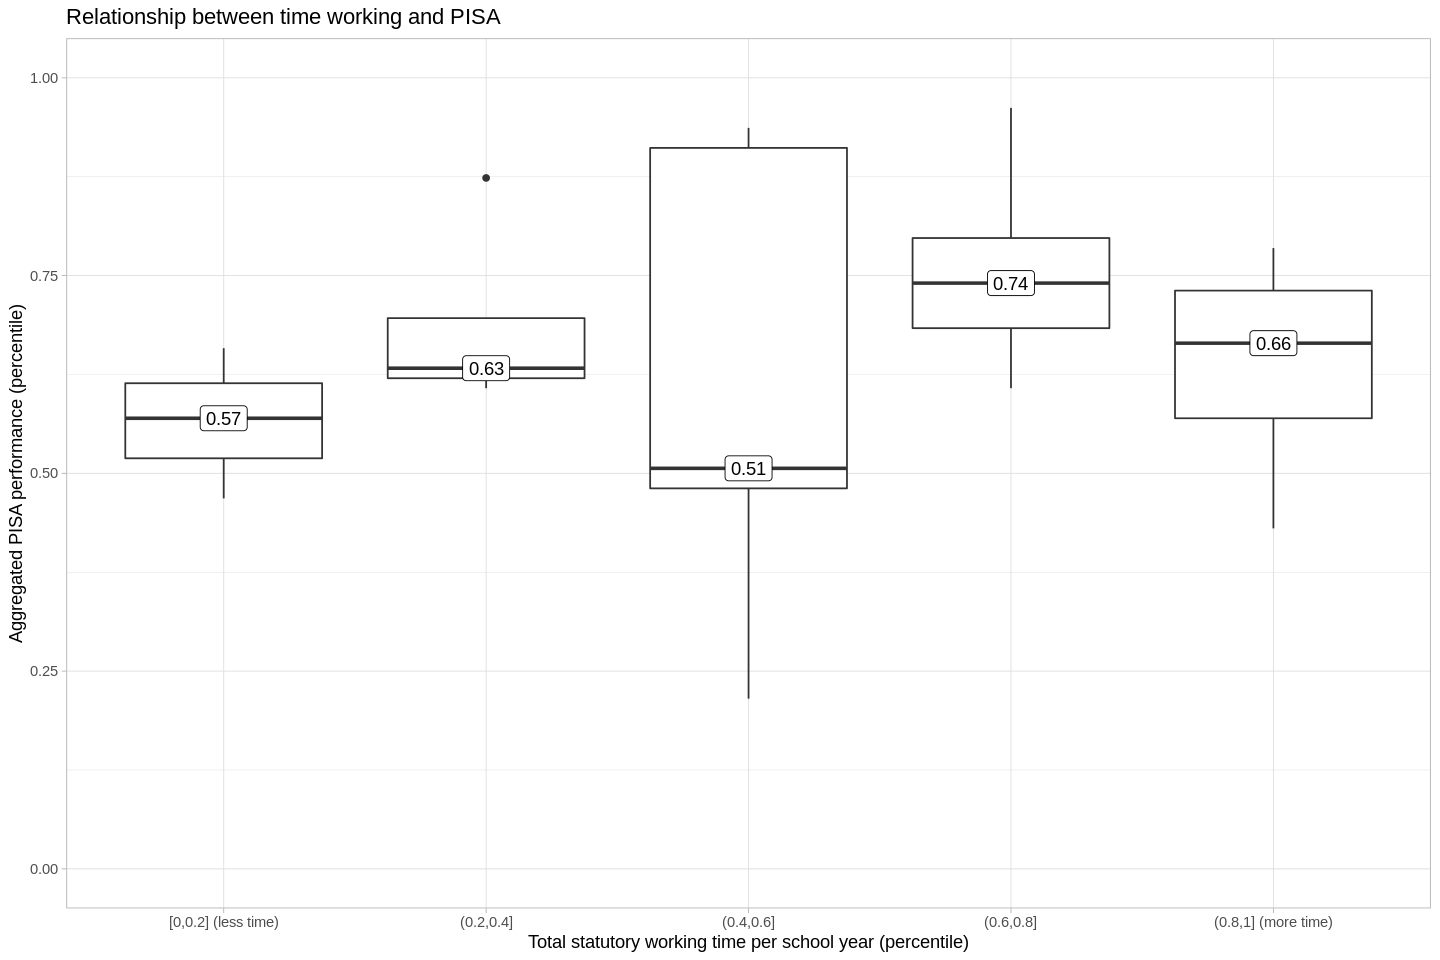

In [30]:
with(Data, inner_join(TimeWorking, PisaAgg, by = 'country')) %>%
ggplot(aes(x = percentile_bin, y = pisa_percentile)) +
geom_boxplot() +
stat_summary(fun = 'median', geom = 'label', aes(label = round(..y.., 2))) +
scale_x_discrete(labels = time_use_labels) +
coord_cartesian(ylim = c(0, 1)) +
theme_light() +
labs(
  title = 'Relationship between time working and PISA',
  x = 'Total statutory working time per school year (percentile)',
  y = 'Aggregated PISA performance (percentile)'
)

## Supplemental modelling

The previous diagrams might indicate non-linear relationships, but I don't want to go p-hacking.
Test a few models (cubic, squared, linear, intercept) using leave one out cross validation-- this is a pretty rigorous test, so I don't think it's p-hacking
- Fit these models on all but 1 country's data
- For each model, then predict this country's data; compare the fitted value to the true value, and store the absolute value of the residual
- Run t-tests, comparing each model's residuals to all the others

In [85]:
# Ratio; our best fitting model is pisa ~ ratio^2

X <-
  inner_join(Data$Ratio, Data$PisaAgg, by = 'country') %>%
  rowid_to_column('row_num') %>%
  select(row_num, value, score)

Loocv <-
X %>%
nest(data = everything()) %>%
expand_grid(loocv_i = X$row_num) %>%
mutate(
  Train = map2(data, loocv_i, ~slice(.x, -.y)),
  Test = map2(data, loocv_i, ~slice(.x, .y)),
  mod_poly3 = map(Train, ~lm(score ~ poly(value, 3), data = .x)),
  mod_poly2 = map(Train, ~lm(score ~ poly(value, 2), data = .x)),
  mod_linear = map(Train, ~lm(score ~ value, data = .x)),
  mod_intercept = map(Train, ~lm(score ~ 1, data = .x)),
) %>%
select(loocv_i, Test, starts_with('mod')) %>%
gather(mod_type, mod, -loocv_i, -Test) %>%
mutate(
  y_fit = map2_dbl(mod, Test, predict),
  y_true = map_dbl(Test, pull, 'score'),
  absolute_residual = abs(y_fit - y_true)
)

with(Loocv, 
  pairwise.t.test(
    x = absolute_residual, 
    g = mod_type, 
    p.adjust.method = 'none', 
    pool.sd = F, 
    paired = T))

Loocv %>%
group_by(mod_type) %>%
summarize(median_absolute_residual = median(absolute_residual)) %>%
ungroup


	Pairwise comparisons using paired t tests 

data:  absolute_residual and mod_type 

           mod_intercept mod_linear mod_poly2
mod_linear 0.460         -          -        
mod_poly2  0.016         0.074      -        
mod_poly3  0.663         0.990      0.437    

P value adjustment method: none 

mod_type,median_absolute_residual
<chr>,<dbl>
mod_intercept,21.88372
mod_linear,20.18165
mod_poly2,17.89325
mod_poly3,19.08565


value,y_fit
<int>,<dbl>
12,489.1651


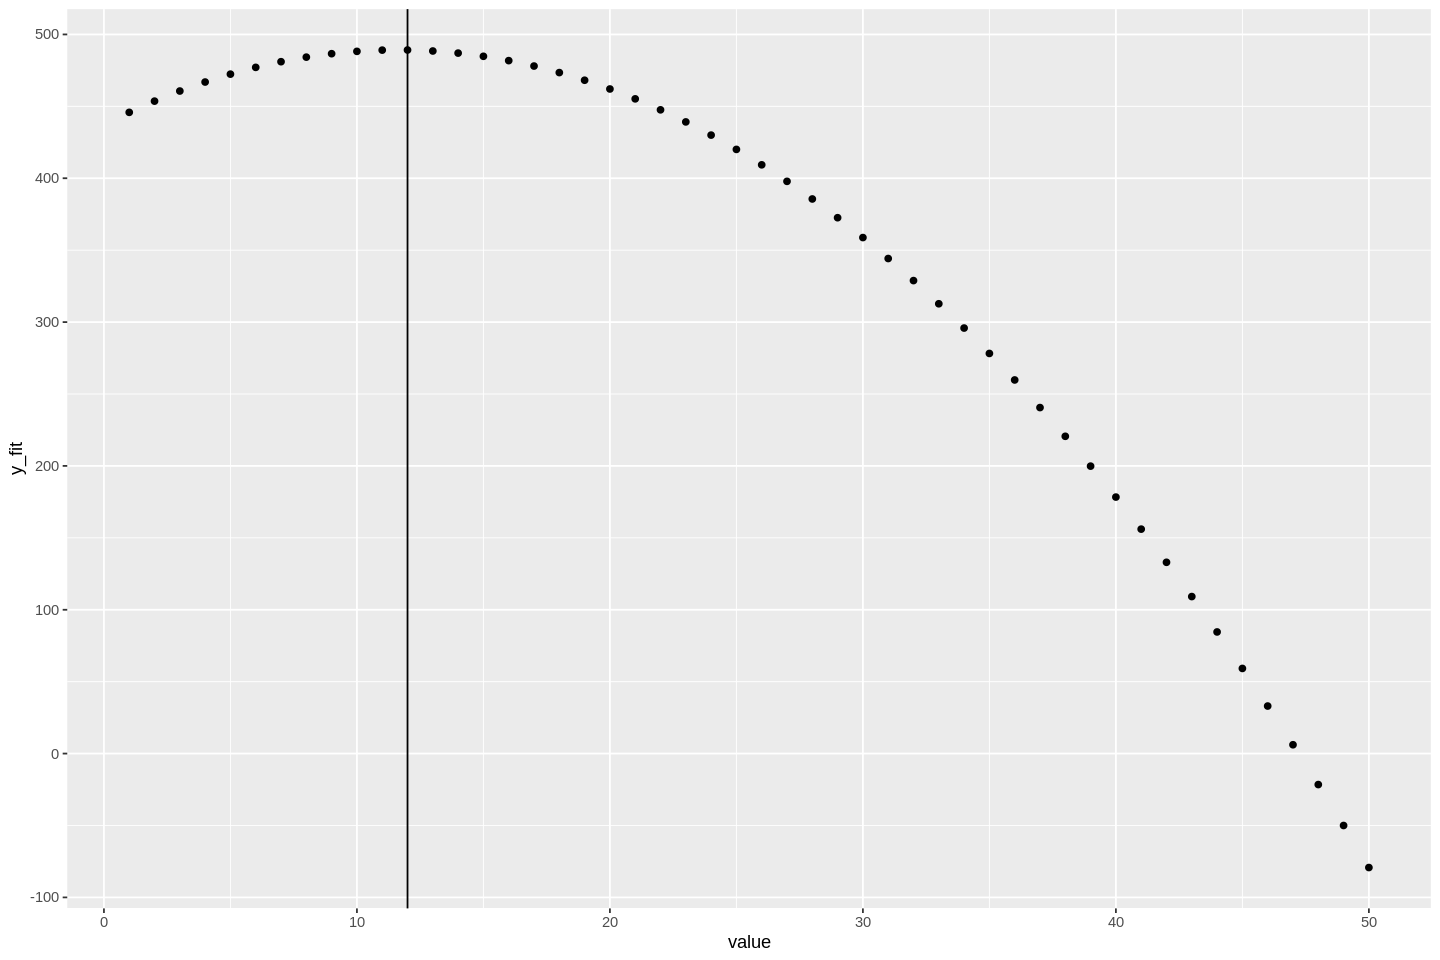

In [100]:
# Optimal ratio seems to be about 12 students:1 teacher

mod2 <- 
  inner_join(Data$Ratio, Data$PisaAgg, by = 'country') %>%
  lm(score ~ poly(value, 2), data = .)
NewData <- enframe(1:50, name = NULL)
NewData$y_fit <- predict(object = mod2, newdata = NewData)

NewData %>%
slice(which.max(y_fit))

ggplot(NewData, aes(x = value, y = y_fit)) +
geom_vline(xintercept = slice(NewData, which.max(y_fit))$value) +
geom_point()

In [86]:
# Time working; we should use the intercept model

X <-
  inner_join(Data$TimeWorking, Data$PisaAgg, by = 'country') %>%
  rowid_to_column('row_num') %>%
  select(row_num, value, score)

Loocv <-
X %>%
nest(data = everything()) %>%
expand_grid(loocv_i = X$row_num) %>%
mutate(
  Train = map2(data, loocv_i, ~slice(.x, -.y)),
  Test = map2(data, loocv_i, ~slice(.x, .y)),
  mod_poly3 = map(Train, ~lm(score ~ poly(value, 3), data = .x)),
  mod_poly2 = map(Train, ~lm(score ~ poly(value, 2), data = .x)),
  mod_linear = map(Train, ~lm(score ~ value, data = .x)),
  mod_intercept = map(Train, ~lm(score ~ 1, data = .x)),
) %>%
select(loocv_i, Test, starts_with('mod')) %>%
gather(mod_type, mod, -loocv_i, -Test) %>%
mutate(
  y_fit = map2_dbl(mod, Test, predict),
  y_true = map_dbl(Test, pull, 'score'),
  absolute_residual = abs(y_fit - y_true)
)

with(Loocv, 
  pairwise.t.test(
    x = absolute_residual, 
    g = mod_type, 
    p.adjust.method = 'none', 
    pool.sd = F, 
    paired = T))

Loocv %>%
group_by(mod_type) %>%
summarize(median_absolute_residual = median(absolute_residual)) %>%
ungroup


	Pairwise comparisons using paired t tests 

data:  absolute_residual and mod_type 

           mod_intercept mod_linear mod_poly2
mod_linear 0.23          -          -        
mod_poly2  0.59          0.94       -        
mod_poly3  0.23          0.36       0.25     

P value adjustment method: none 

mod_type,median_absolute_residual
<chr>,<dbl>
mod_intercept,13.12500
mod_linear,13.87380
mod_poly2,13.10754
mod_poly3,14.49613


## LOESS models and scatterplots representing the relationships between teacher metrics and PISA scores

In [31]:
report_spearman_cor <- function(Htest){
  str_c(
    'Spearman\'s rank correlation rho = ', 
    round(Htest$estimate, 2), 
    '(s = ', scales::comma(Htest$statistic), 
    if_else(
      Htest$p.value < 0.05, 
      ' p < 0.05; significant)',
      ' p >= 0.05; not significant)'
    ),
    '\nRegression line represents LOESS model')
}

Warning message in cor.test.default(value, score, method = "s"):
“Cannot compute exact p-value with ties”
Warning message:
“ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


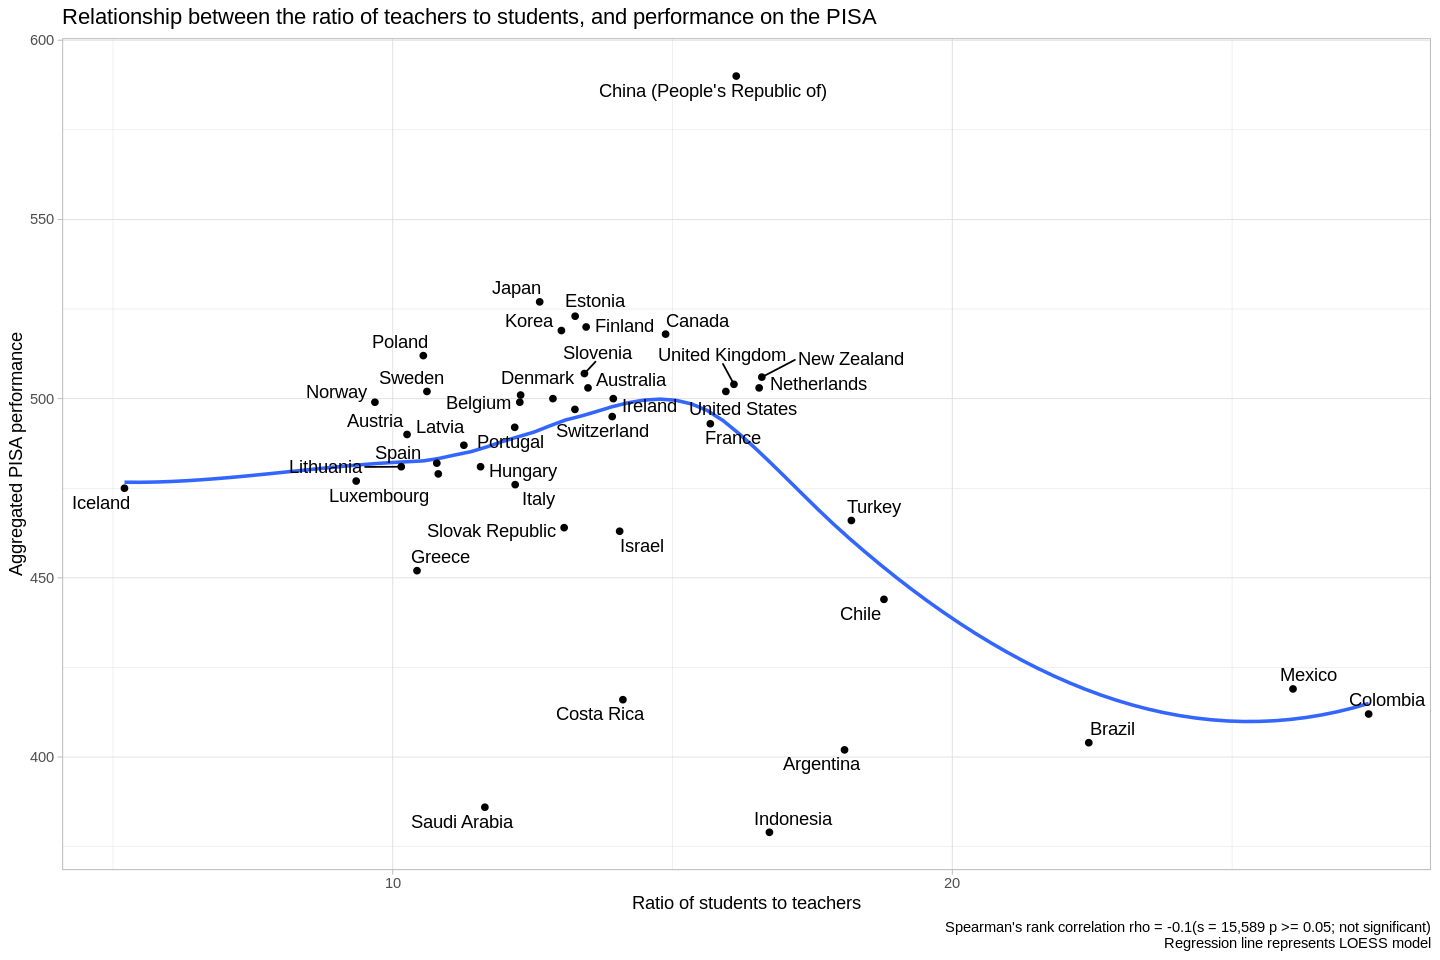

In [32]:
my_caption <- 
  with(Data, inner_join(PisaAgg, Ratio, by = 'country')) %>%
  drop_na %>%
  with(., cor.test(value, score, method = 's')) %>%
  report_spearman_cor

with(Data, inner_join(PisaAgg, Ratio, by = 'country')) %>%
drop_na %>%
ggplot(aes(x = value, y = score, label = country)) +
geom_smooth(se = F, method = 'loess', formula = 'y ~ x') +
geom_text_repel() +
geom_point() +
theme_light() +
labs(
  x = 'Ratio of students to teachers', 
  y = 'Aggregated PISA performance', 
  title = 'Relationship between the ratio of teachers to students, and performance on the PISA',
  caption = my_caption
  )

Warning message in cor.test.default(value, score, method = "s"):
“Cannot compute exact p-value with ties”


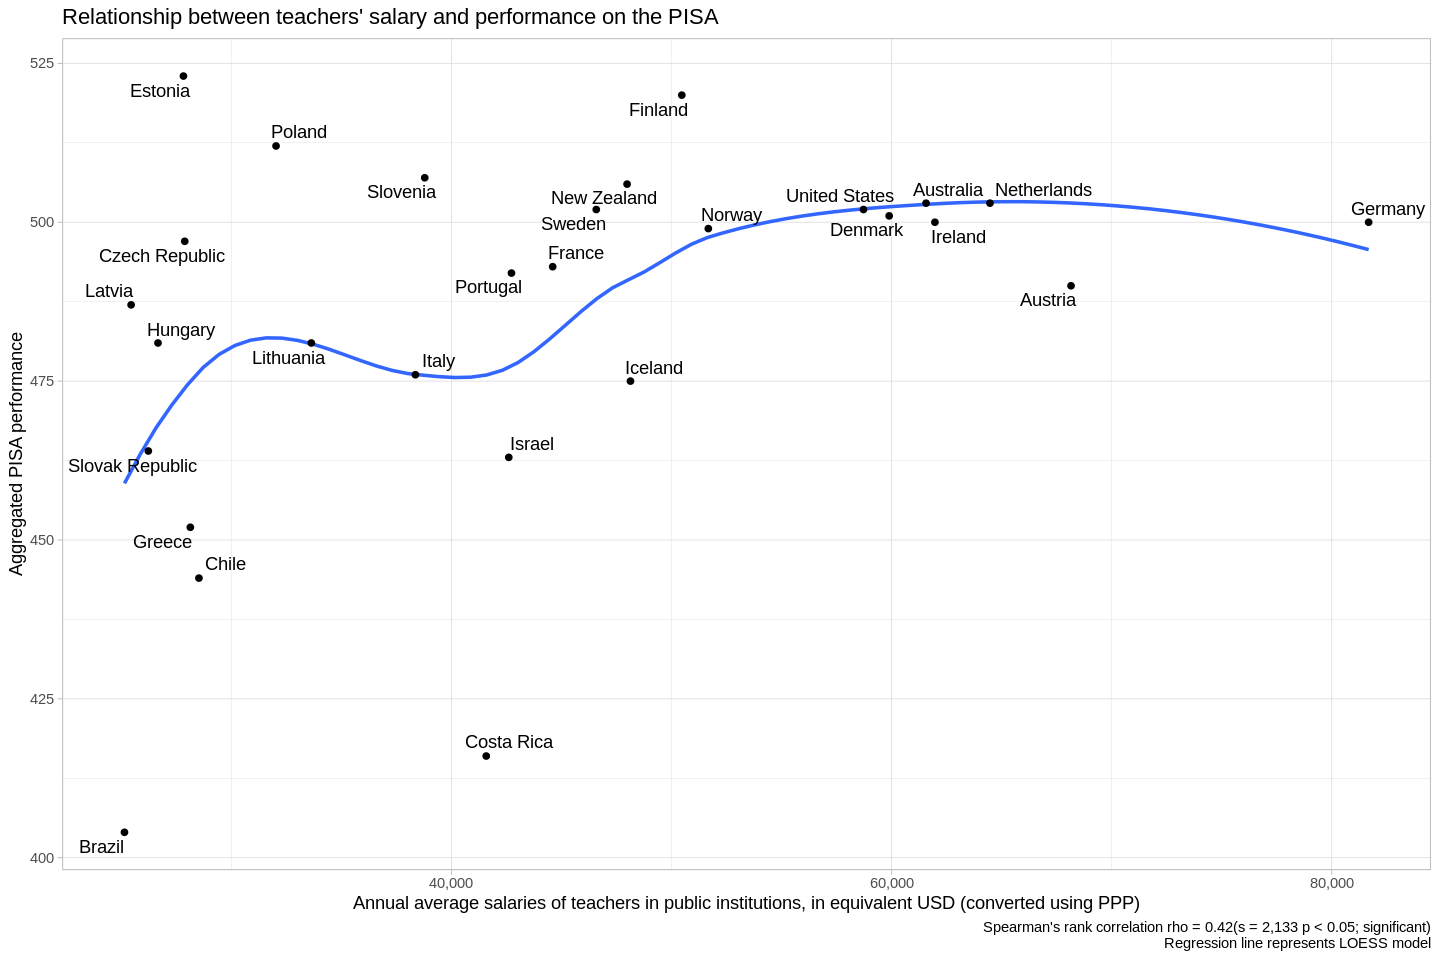

In [33]:
my_caption <-
  with(Data, inner_join(PisaAgg, Salary, by = 'country')) %>%
  drop_na %>%
  with(., cor.test(value, score, method = 's')) %>%
  report_spearman_cor

with(Data, inner_join(PisaAgg, Salary, by = 'country')) %>%
drop_na %>%
ggplot(aes(x = value, y = score, label = country)) +
geom_smooth(se = F, method = 'loess', formula = 'y ~ x') +
geom_text_repel() +
geom_point() +
scale_x_continuous(labels = scales::comma_format(1)) +
theme_light() +
labs(
  x = 'Annual average salaries of teachers in public institutions, in equivalent USD (converted using PPP)',
  y = 'Aggregated PISA performance', 
  title = 'Relationship between teachers\' salary and performance on the PISA',
  caption = my_caption
  )

Warning message in cor.test.default(value, score, method = "s"):
“Cannot compute exact p-value with ties”


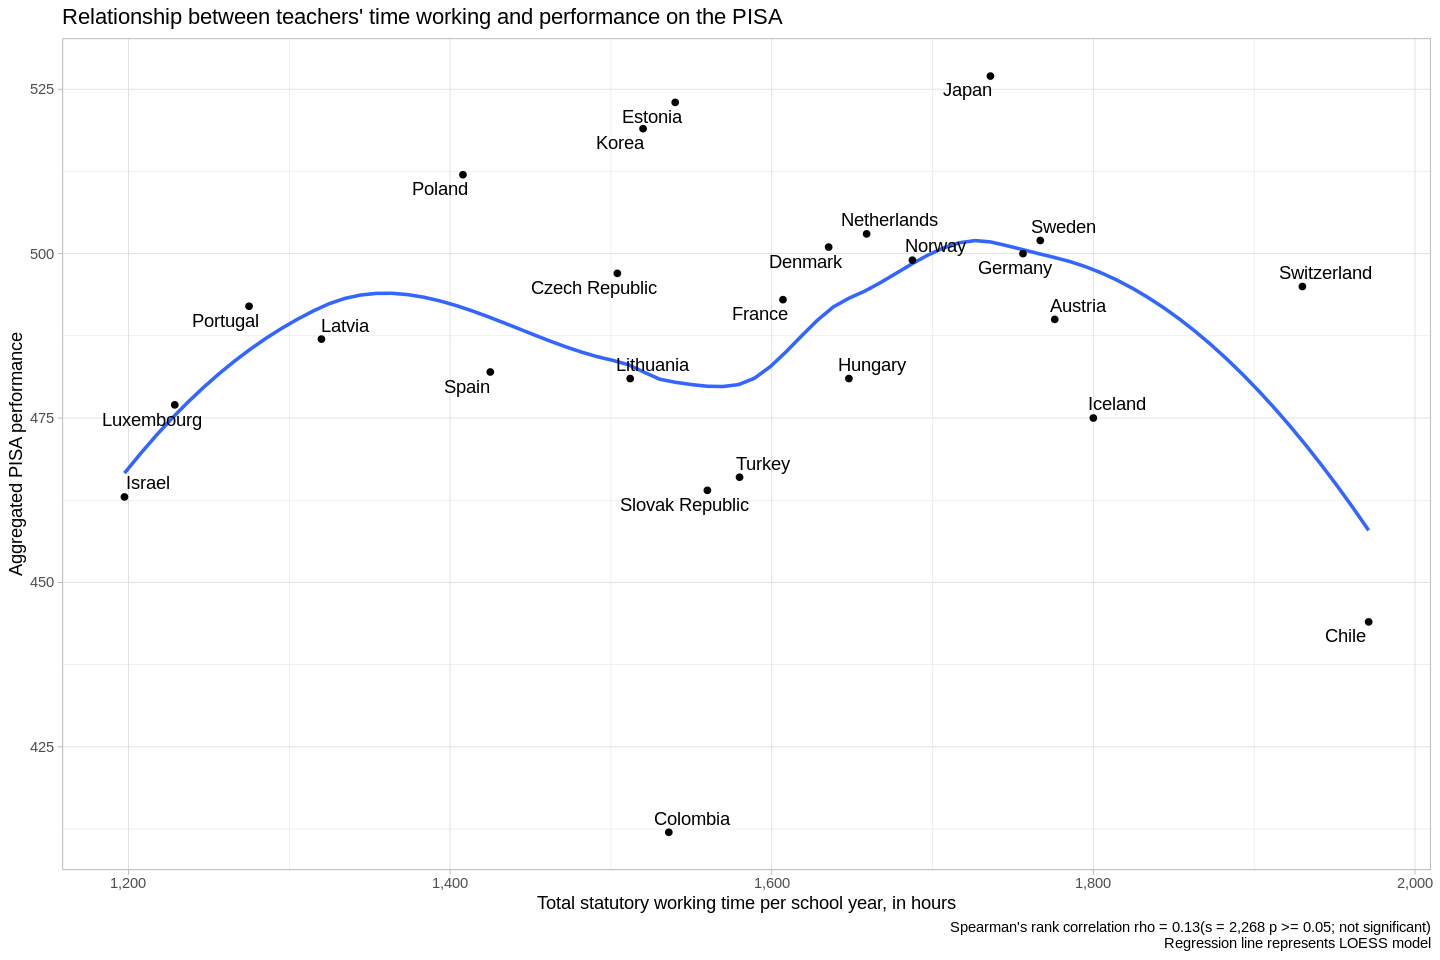

In [34]:
my_caption <-
  with(Data, inner_join(PisaAgg, TimeWorking, by = 'country')) %>%
  drop_na %>%
  with(., cor.test(value, score, method = 's')) %>%
  report_spearman_cor

with(Data, inner_join(PisaAgg, TimeWorking, by = 'country')) %>%
drop_na %>%
ggplot(aes(x = value, y = score, label = country)) +
geom_smooth(se = F, method = 'loess', formula = 'y ~ x') +
geom_text_repel() +
geom_point() +
scale_x_continuous(labels = scales::comma_format(1)) +
theme_light() +
labs(
  x = 'Total statutory working time per school year, in hours',
  y = 'Aggregated PISA performance', 
  title = 'Relationship between teachers\' time working and performance on the PISA',
  caption = my_caption
)

Top-line summary of models

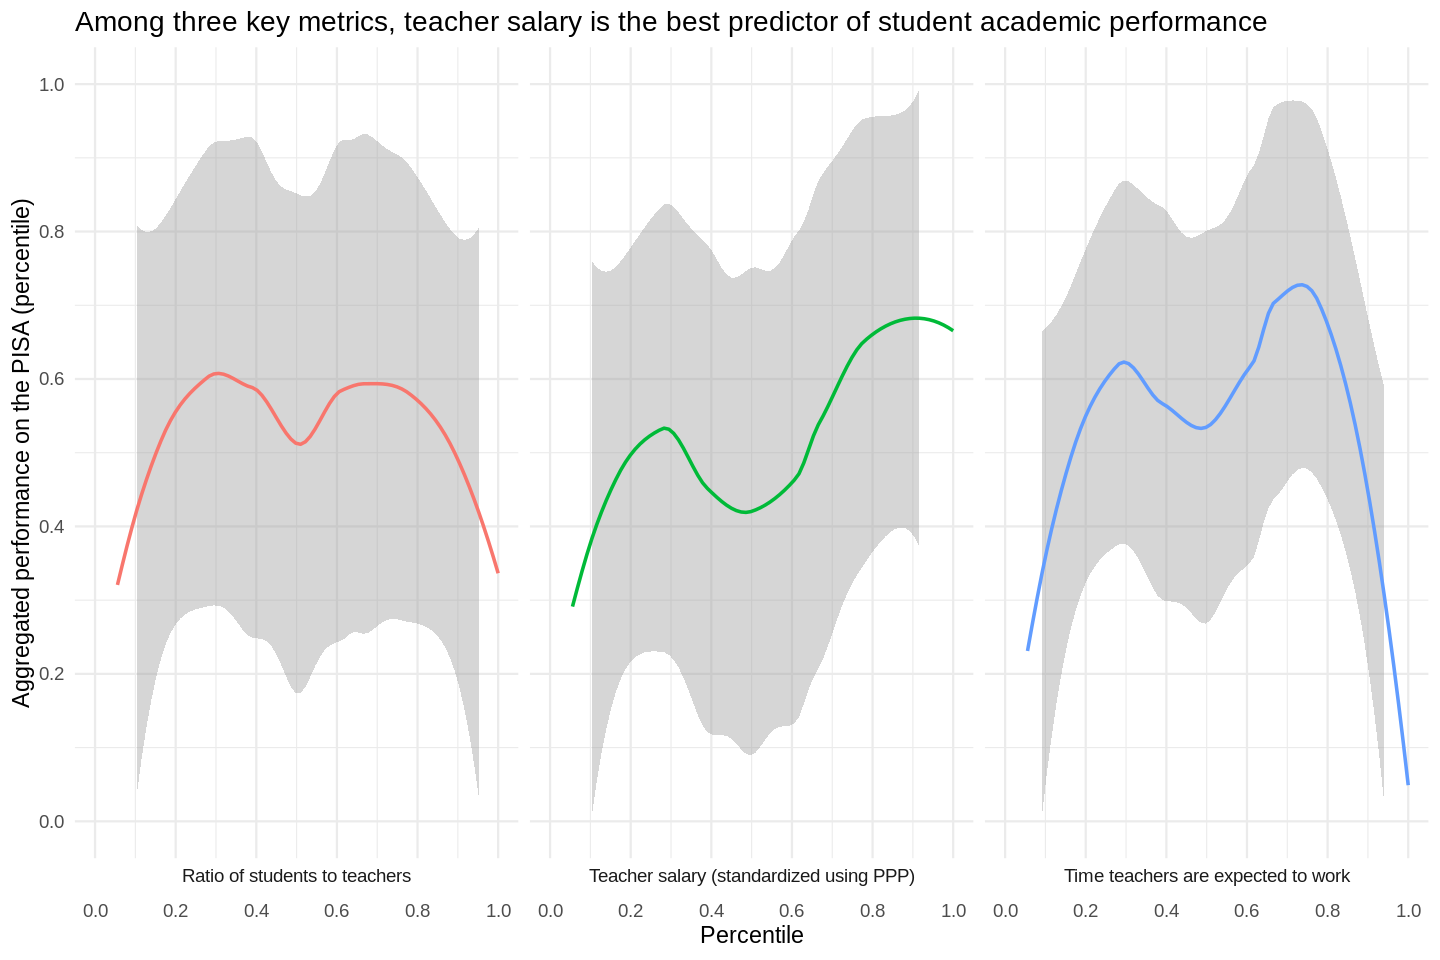

In [35]:
Data$Salary %>%
select(country, 'Teacher salary (standardized using PPP)' = value) %>%
inner_join(
  Data$Ratio %>%
  select(country, 'Ratio of students to teachers' = value), by = 'country'
) %>%
inner_join(
  Data$TimeWorking %>%
  select(country, 'Time teachers are expected to work' = value), by = 'country'
) %>%
inner_join(
  Data$PisaAgg %>%
  select(country, 'Aggregated performance on the PISA' = score), by = 'country'
) %>%
mutate_if(is.numeric, ~ecdf(.)(.)) %>%
gather(variable, value, -country, -`Aggregated performance on the PISA`) %>%

ggplot(aes(x = value, y = `Aggregated performance on the PISA`, group = variable)) +
geom_smooth(method = 'loess', formula = 'y ~ x', se = T, aes(color = variable)) +
facet_wrap(~variable, strip.position = 'bottom') +
scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2)) +
scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2)) +
theme_minimal(base_size = 14) +
theme(legend.position = 'none') +
labs(
  x = 'Percentile',
  y = 'Aggregated performance on the PISA (percentile)',
  title = 'Among three key metrics, teacher salary is the best predictor of student academic performance'
)

# Social outcomes

It'd be nice to use a structural equation model to express the relationships between these variables, and it'd be even nicer to use latent variables to represent larger patterns where applicable.
Unfortunately, a few key packages for dimensionality reduction don't work with this R kernel, in this Colab notebook. 
So, I'll rationalize and say that with only 4 manifest social outcome variables, and only 3 manifest teacher variables, I can just look at correlation matrices and construct some common-sense latent variables.

Latent variable 1:
- Mean # of hours worked 
- % of adults who reported it's difficult for them to fulfill family responsibilities for lack of time

Latent variable 2:
- Work flexibility
- % of adults who read books at least once a week

In [36]:
rho <-
  Data$SocialOutcomes %>%
  select(-indicator_concise) %>%
  spread(indicator, value) %>%
  rename(
    'Percentage of adults who read books at least once a week' = 'Percentage of adults who read books at least once a week, by labour-force status, gender, age and educational attainment'
  ) %>%
  select_if(is.numeric) %>%
  mutate_all(~as.vector(scale(.))) %>%
  cor(., use = 'pairwise.complete.obs', method = 's')

rho[upper.tri(rho, diag = T)] <- NA_real_
round(rho, 2)

,Mean number of hours worked per week in the main job among employed adults,Percentage of adults who read books at least once a week,Percentage of adults who reported that over the last 12 months it has been difficult for them to fulfill their family responsibilities because of the amount of time they spend at work,Percentage of employed adults who report having a high or very high flexibility of working hours in their main job
Mean number of hours worked per week in the main job among employed adults,NA,NA,NA,NA
Percentage of adults who read books at least once a week,-0.55,NA,NA,NA
Percentage of adults who reported that over the last 12 months it has been difficult for them to fulfill their family responsibilities because of the amount of time they spend at work,0.49,-0.31,NA,NA
Percentage of employed adults who report having a high or very high flexibility of working hours in their main job,-0.21,0.17,-0.24,NA


Latent variable:
- Time working
- Salary

Our lonely manifest variable:
- Ratio of students to teachers

In [37]:
rho <-
  Data$Salary %>% 
  select(country, salary = value) %>%

  full_join(
    Data$Ratio %>%
    select(country, ratio_students_to_teachers = value), by = 'country'
  ) %>%

  full_join(
    Data$TimeWorking %>%
    select(country, time_working = value), by = 'country'
  ) %>%
  select_if(is.numeric) %>%
  mutate_all(scale) %>%
  cor(method = 's', use = 'pairwise.complete.obs') 
  
rho[upper.tri(rho, diag = T)] <- NA_real_
round(rho, 2)

,salary,ratio_students_to_teachers,time_working
salary,NA,NA,NA
ratio_students_to_teachers,0.03,NA,NA
time_working,0.28,0.07,NA


In [38]:
X <-
  # Variables about teachers
  Data$Salary %>% 
  select(country, salary = value) %>%

  full_join(
    Data$Ratio %>%
    select(country, ratio_students_to_teachers = value), by = 'country'
  ) %>%

  full_join(
    Data$TimeWorking %>%
    select(country, time_working = value), by = 'country'
  ) %>%

  # PISA
  full_join(
    Data$PisaAgg %>%
    select(country, pisa = score), by = 'country'
  ) %>%

  # Social outcomes
  full_join(
    Data$SocialOutcomes %>%
    select(country, indicator_concise, value) %>%
    spread(indicator_concise, value), by = 'country'
  ) %>%
  select(-country) %>%
  mutate_all(~as.vector(scale(.)))

In [39]:
sem_formula <- '
  # latent variables
  teacher_time_and_pay =~ time_working + salary
  outcome_flex_and_read =~ work_flexibility + read_books
  outcome_work_and_home_stress =~ hours_worked + conflict_work_family_time

  # regressions
  outcome_flex_and_read ~ teacher_time_and_pay
  outcome_flex_and_read ~ ratio_students_to_teachers
  outcome_work_and_home_stress ~ teacher_time_and_pay
  outcome_work_and_home_stress ~ ratio_students_to_teachers

  # correlations
  pisa ~~ teacher_time_and_pay
  pisa ~~ ratio_students_to_teachers
  pisa ~~ outcome_flex_and_read 
  pisa ~~ outcome_work_and_home_stress 
'

In [40]:
anova(cfa(sem_formula, X))

Warning message in lav_object_post_check(object):
“lavaan WARNING: some estimated ov variances are negative”


,Df,AIC,BIC,Chisq,Chisq diff,Df diff,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Saturated,0,NA,NA,0.00000,NA,NA,NA
Model,13,239.5754,252.5692,19.45152,19.45152,13,0.1097557


In [41]:
cfa(sem_formula, X) %>%
summary

Warning message in lav_object_post_check(object):
“lavaan WARNING: some estimated ov variances are negative”


lavaan 0.6-8 ended normally after 109 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        23
                                                      
                                                  Used       Total
  Number of observations                            13          87
                                                                  
Model Test User Model:
                                                      
  Test statistic                                19.452
  Degrees of freedom                                13
  P-value (Chi-square)                           0.110

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Latent Variables:
                                  Estimate  Std.Err  z-value  P(>|z|)
  teacher